[INFO] loading images...


C:\Anaconda\envs\myenv\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
50/50 [==============================] - 70s 1s/step - loss: 0.2895 - accuracy: 0.9106 - val_loss: 0.1518 - val_accuracy: 0.9481
Epoch 2/20
50/50 [==============================] - 58s 1s/step - loss: 0.1516 - accuracy: 0.9514 - val_loss: 0.1020 - val_accuracy: 0.9506
Epoch 3/20
50/50 [==============================] - 54s 1s/step - loss: 0.1051 - accuracy: 0.9621 - val_loss: 0.0659 - val_accuracy: 0.9802
Epoch 4/20
50/50 [==============================] - 56s 1s/step - loss: 0.0706 - accuracy: 0.9798 - val_loss: 0.0468 - val_accuracy: 0.9852
Epoch 5/20
50/50 [==============================] - 55s 1s/step - loss: 0.0580 - accuracy: 0.9861 - val_loss: 0.0351 - val_accuracy: 0.9901
Epoch 6/20
50/50 [==============================] - 57s 1s/step - loss: 0.0445 - accuracy: 0.9912 - val_loss: 0.0283 - val_accuracy: 0.9951
Epoch 7/20
50/50 [==============================] - 55s 1s/step - loss: 0.0384 - accuracy: 0.9899 - val_loss: 

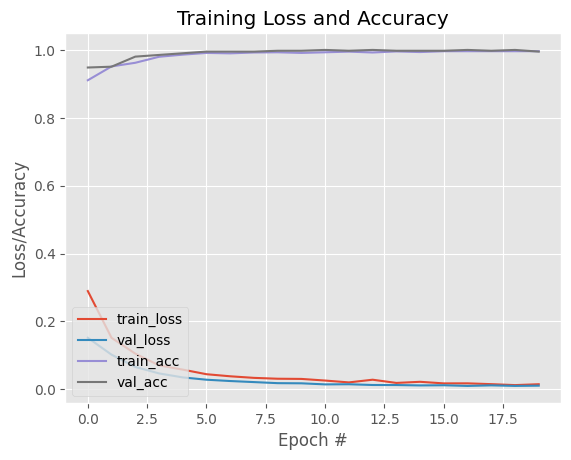

In [7]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"D:\Niruppa\Working\DEEP LEARNING\CV\Facemask\dataset"
CATEGORIES = ["with_mask","without_mask"]  # Ensure folders exist here

# load and preprocess the images
print("[INFO] loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        try:
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)

            data.append(image)
            labels.append(category)
        except Exception as e:
            print(f"[WARNING] Skipped image {img_path} due to error: {e}")

# one-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# convert to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# split data
(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size=0.20, stratify=labels, random_state=42
)

# data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# load MobileNetV2 without the head FC layers
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# build custom head for the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# attach head to base model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze base model layers
for layer in baseModel.layers:
    layer.trainable = False

# compile model using legacy Adam (to use 'decay')
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train model
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

# evaluate model
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# save the model
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot training metrics
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
